<a href="https://colab.research.google.com/github/VajinderKaur/TheSparksFoundation_Task2/blob/main/Decision_Tree_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Task - Prediction using Decision Tree Algorithm </h1>
<h4>Vajinder Kaur, Data Science and Business Analytics Intern, The Sparks Foundation</h4>

---



This project focuses on enhancing sentiment analysis using ensemble learning techniques. Utilizing a Kaggle dataset containing text data labeled with sentiments ( empty, happiness, sadness, worry, surprise, hate, fun, relief, neutral, anger, boredom, enthusiasm, love ). Initially a decision tree algorithm was employed, achieving 23% accuracy. Through hyperparameter tuning and AdaBoostClassifier with Decision Tree as the base estimator, accuracy was boosted to 59%. Additionally, Explored Random Forest for further performance enhancement.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier


from IPython.display import display

import nltk
nltk.download('vader_lexicon')
import re
from nltk.corpus import stopwords
!python -m nltk.downloader stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from google.colab import drive

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h1>Imports:</h1>

---



1. **numpy, pandas, matplotlib.pyplot, seaborn**: Libraries for data manipulation,visualization, and numerical operations.
2. **train_test_split**: Function from scikit-learn for splitting data into training and testing sets.
3. **hstack**: Function from scipy.sparse for horizontally stacking sparse matrices.
4. **TfidfVectorizer**: Class from scikit-learn for converting text data into TF-IDF features.
5. **LabelEncoder**: Class from scikit-learn for encoding categorical labels into numerical values.
6. **DecisionTreeClassifier**: Class from scikit-learn for building decision tree models.
7. **XGBClassifier**: Class from XGBoost library for building gradient boosting models.
8. **accuracy_score, classification_report, confusion_matrix**: Functions for evaluating model performance.
9. **compute_class_weight**: Function from scikit-learn for computing class weights.
10. **display**: Function for displaying objects in a Jupyter notebook.
11. **drive**: Module for accessing Google Drive files in a Google Colab environment.


In [2]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tweet_emotions.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


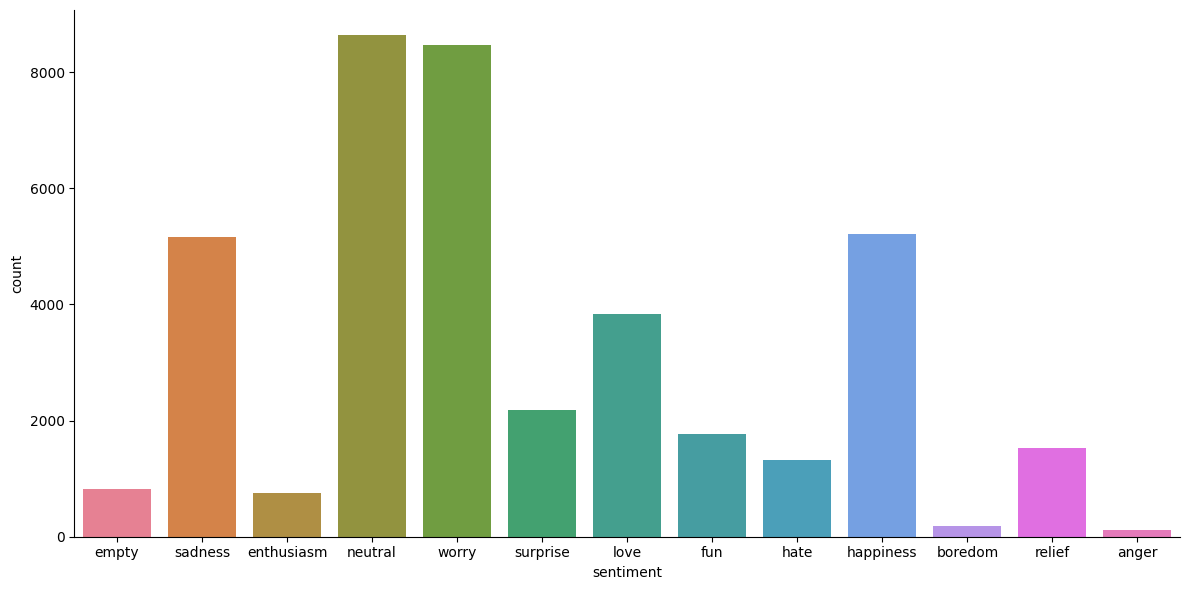

In [3]:
sns.catplot(data=df, x='sentiment', kind='count', height=6, aspect=2, hue='sentiment', legend=False)

In [4]:
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to extract sentiment scores from text
def extract_sentiment_scores(text):
    scores = sia.polarity_scores(text)
    return scores['neg'], scores['neu'], scores['pos']

# Apply the function to the text data to extract sentiment scores
df['neg_score'], df['neu_score'], df['pos_score'] = zip(*df['content'].map(extract_sentiment_scores))

def map_sentiment_category(sentiment):
    if sentiment in ['anger', 'hate', 'sadness', 'worry', 'boredom', 'empty']:
        return 'negative'
    elif sentiment in ['neutral']:
        return 'neutral'
    else:
        return 'positive'

# Apply the mapping function to the 'sentiment' column
df['sentiment_category'] = df['sentiment'].apply(map_sentiment_category)

# Display the dataframe with sentiment scores
display(df)

,tweet_id,sentiment,content,neg_score,neu_score,pos_score,sentiment_category
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...,0.200,0.800,0.000,negative
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...,0.000,1.000,0.000,negative
2,1956967696,sadness,Funeral ceremony...gloomy friday...,0.556,0.444,0.000,negative
3,1956967789,enthusiasm,wants to hang out with friends SOON!,0.000,0.639,0.361,positive
4,1956968416,neutral,@dannycastillo We want to trade with someone w...,0.165,0.767,0.068,neutral
...,...,...,...,...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor,0.000,1.000,0.000,neutral
39996,1753919001,love,Happy Mothers Day All my love,0.000,0.336,0.664,positive
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...,0.000,0.857,0.143,positive
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,0.000,0.734,0.266,positive


In [5]:
df.shape

(40000, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            40000 non-null  int64  
 1   sentiment           40000 non-null  object 
 2   content             40000 non-null  object 
 3   neg_score           40000 non-null  float64
 4   neu_score           40000 non-null  float64
 5   pos_score           40000 non-null  float64
 6   sentiment_category  40000 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 2.1+ MB


In [7]:
for i in df.columns:
  dis = len(df[i].unique())
  print(f"{i} - {dis}")

tweet_id - 40000
sentiment - 13
content - 39827
neg_score - 695
neu_score - 811
pos_score - 788
sentiment_category - 3


In [8]:
df['sentiment_category'].value_counts()

sentiment_category
negative    16063
positive    15299
neutral      8638
Name: count, dtype: int64

In [9]:

df.duplicated().sum()

0

In [10]:
df.drop(['tweet_id'],axis=1,inplace=True)
df.head()

,sentiment,content,neg_score,neu_score,pos_score,sentiment_category
0,empty,@tiffanylue i know i was listenin to bad habi...,0.200,0.800,0.000,negative
1,sadness,Layin n bed with a headache ughhhh...waitin o...,0.000,1.000,0.000,negative
2,sadness,Funeral ceremony...gloomy friday...,0.556,0.444,0.000,negative
3,enthusiasm,wants to hang out with friends SOON!,0.000,0.639,0.361,positive
4,neutral,@dannycastillo We want to trade with someone w...,0.165,0.767,0.068,neutral


In [11]:
for c in df.columns:
    print("---- %s ---" % c)
    print(df[c].value_counts())

---- sentiment ---
sentiment
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64
---- content ---
content
I just received a mothers day card from my lovely daughter wishing my a happy mothers day  http://tr.im/kWK9                            14
FREE UNLIMITED RINGTONES!!! - http://tinyurl.com/freeringring - USA ONLY - Awesome 4 iphone                                             13
Happy Mother's Day!                                                                                                                     10
Happy Mothers Day                                                                                                                       10
happy mother's day                                                                                                   

In [12]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
df['sentiment'] = enc.fit_transform(df[['sentiment']])
df['sentiment_category'] = enc.fit_transform(df[['sentiment_category']])

df.head()

,sentiment,content,neg_score,neu_score,pos_score,sentiment_category
0,2.0,@tiffanylue i know i was listenin to bad habi...,0.200,0.800,0.000,0.0
1,10.0,Layin n bed with a headache ughhhh...waitin o...,0.000,1.000,0.000,0.0
2,10.0,Funeral ceremony...gloomy friday...,0.556,0.444,0.000,0.0
3,3.0,wants to hang out with friends SOON!,0.000,0.639,0.361,2.0
4,8.0,@dannycastillo We want to trade with someone w...,0.165,0.767,0.068,1.0


Counting Total Number of Words in the Content Column of Dataframe in order to reduce the number of words by Stemming !

In [13]:
total_word_count = 0
for content in df['content']:
    total_word_count += sum(1 for _ in content.split())
print(total_word_count)

528675


In [14]:
ps = PorterStemmer()
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [ps.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = " ".join(stemmed_content)
    return stemmed_content

df['content'] = df['content'].apply(stemming)

In [15]:
total_word_count = 0
for content in df['content']:
    total_word_count += sum(1 for _ in content.split())
print(total_word_count)

310033


In [16]:
X = df[['content', 'neg_score', 'neu_score', 'pos_score','sentiment_category']]
Y = df['sentiment']
X.shape

(40000, 5)

In [17]:
tfidf_transformer = ('tfidf', TfidfVectorizer(), 'content')

In [18]:
numeric_features = ['neg_score', 'neu_score', 'pos_score','sentiment_category']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        tfidf_transformer,
        ('num', numeric_transformer, numeric_features)
    ]
)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

# Create the full pipeline with AdaBoostClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__learning_rate': [0.1, 1.0],
    'classifier__base_estimator__max_depth': [1, 2],
    'classifier__base_estimator__min_samples_split': [2, 10],
    'classifier__base_estimator__min_samples_leaf': [1, 5]
}

RandomizedSearchCV: 60it [04:11,  3.80s/it]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
RandomizedSearchCV: 60it [04:16,  4.27s/it]


Model: AdaBoostClassifier with DecisionTreeClassifier
Best parameters found: {'classifier__n_estimators': 50, 'classifier__learning_rate': 1.0, 'classifier__base_estimator__min_samples_split': 10, 'classifier__base_estimator__min_samples_leaf': 5, 'classifier__base_estimator__max_depth': 2}
Best cross-validation accuracy: 0.58975
Test set accuracy with AdaBoost: 0.5971875
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        44
         1.0       0.00      0.00      0.00        68
         2.0       0.22      0.01      0.01       314
         3.0       0.12      0.04      0.06       326
         4.0       0.26      0.05      0.08       675
         5.0       0.39      0.81      0.53      2080
         6.0       0.52      0.20      0.29       521
         7.0       0.65      0.41      0.50      1511
         8.0       1.00      1.00      1.00      3490
         9.0       0.41      0.09      0.15       647
       

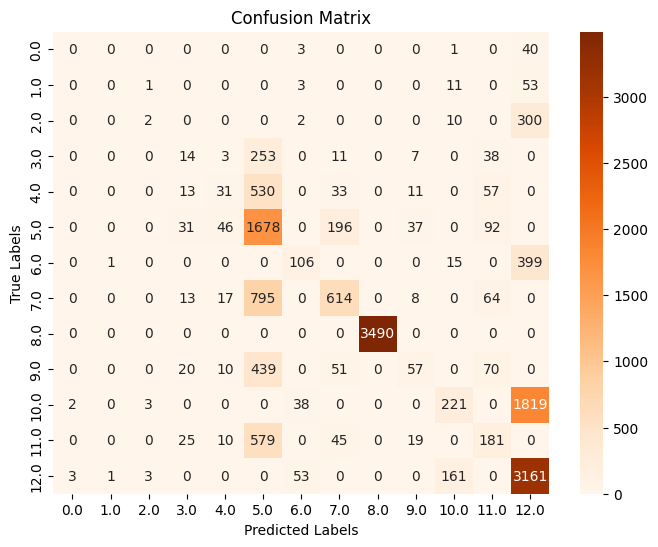

In [21]:
from tqdm import tqdm
import joblib
from contextlib import contextmanager

# Context manager for joblib with tqdm
@contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

n_candidates = 20  # Fixed number of random samples
with tqdm_joblib(tqdm(desc="RandomizedSearchCV", total=n_candidates)) as progress_bar:
    random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=n_candidates, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)

print("Model: AdaBoostClassifier with DecisionTreeClassifier")
# Get the best parameters and the best score
best_params = random_search.best_params_
best_score = random_search.best_score_
print(f'Best parameters found: {best_params}')
print(f'Best cross-validation accuracy: {best_score}')

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test set accuracy with AdaBoost: {test_accuracy}')

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Length of text feature names: 27262
Length of numeric features: 4
Total length of all feature names: 27266
Expected number of features by the decision tree: 27266


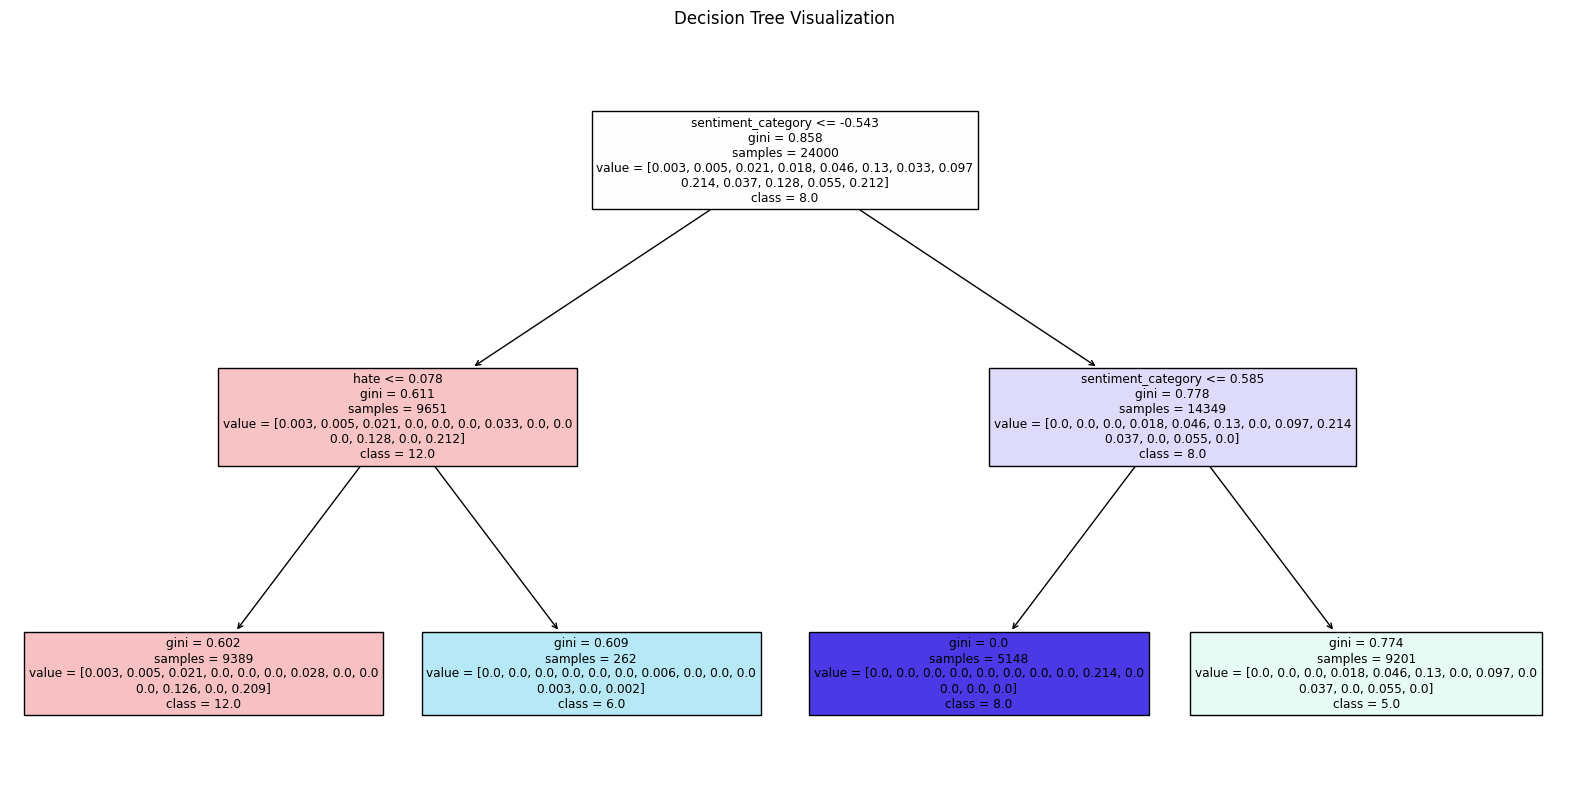

In [25]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize a subtree of the decision tree
def visualize_subtree(adaboost_classifier, feature_names, class_names, base_estimator_index, filename=None):
    # Extract the list of base estimators (decision trees) from AdaBoostClassifier
    base_estimators = adaboost_classifier.estimators_

    # Extract the base estimator (decision tree) from the list at the specified index
    base_estimator = base_estimators[base_estimator_index]

    # Convert class names to strings
    class_names = [str(class_name) for class_name in class_names]

    # Visualize the decision tree
    plt.figure(figsize=(20, 10))
    plot_tree(base_estimator, feature_names=feature_names, class_names=class_names, filled=True)
    plt.title('Decision Tree Visualization')
    if filename:
        plt.savefig(filename)
    plt.show()

# Extract feature names from preprocessor
text_feature_names = best_model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()

# Get the feature names for numeric features including 'sentiment_category'
numeric_features = ['neg_score', 'neu_score', 'pos_score', 'sentiment_category']

# Concatenate feature names
all_feature_names = np.concatenate((text_feature_names, numeric_features))

# Debug: Print lengths of feature names and expected number of features
print("Length of text feature names:", len(text_feature_names))
print("Length of numeric features:", len(numeric_features))
print("Total length of all feature names:", len(all_feature_names))
print("Expected number of features by the decision tree:", best_model.named_steps['classifier'].estimators_[0].n_features_in_)

# Example: Visualize the decision tree at index 0 in the AdaBoostClassifier
visualize_subtree(best_model.named_steps['classifier'],
                  all_feature_names,
                  best_model.named_steps['classifier'].classes_,
                  base_estimator_index=0,
                  filename="subtree_visualization")
